## 3M Data Science Summer Internship 2023: Take-Home Assessment
##### Name: Guilherme de Sousa, PhD Candidate
##### Contact: gdesousa@umd.edu    https://guidesousa.com

### Summary of results:
1) 
2) 

### Assumptions & limitations:
- I considered the snow tubing service to happen when temperature < 32F & river tubing when temperature > 32F
- I counted snowing as precipitation


### Future work:
- 

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timezone, timedelta

In [2]:
# Auxiliary functions
def normalize(df, cols=None, norm='mean'):
    result = df.copy()
    if not cols:
        cols = df.columns
    for c in cols:
        if norm == 'mean':
            mea_value = df[c].mean()
            std_value = df[c].std()
            result[c] = (df[c] - mea_value) / std_value
        if norm == 'minmax':
            min_value = df[c].min()
            max_value = df[c].max()
            result[c] = (df[c] - min_value) / (max_value - min_value)
    return result

In [3]:
from os import listdir, getcwd

##############
# Load files #
##############
# PATH
PATH = getcwd() + '/data/'
files = listdir(PATH)

# Location, Holiday and Weather dataframes
df_location = pd.read_csv(PATH+'location_data.csv')
df_holiday = pd.read_csv(PATH+'holiday_data.csv')
df_weather = pd.read_csv(PATH+'weather_data.csv').astype({'date':'datetime64[ns]'})
df_weather['rent'] = df_weather['temperature'].apply(lambda x: 'snow' if x < 32 else 'river')

# Transactions dataframe
df_transaction = []
for file in files:
    if ('system1' in file):
        df_transaction.append(pd.read_csv(PATH+file, index_col=None, header=0))
    if ('system2' in file):
        df_transaction.append(pd.read_csv(PATH+file, index_col=None, header=0, sep='\t'))
    if ('system3' in file):
        with open(PATH + file) as f:
            data = json.loads(f.read())
            df_transaction.append(pd.json_normalize(data))
df_transaction = pd.concat(df_transaction)
# Remove $ symbol in System 1
df_transaction['profit'] = df_transaction['profit'].apply(lambda x: str(x).split('$')[1] if '$' in str(x) else x)
# Fix negative values of System 2 that writes '0-x' for negative values
df_transaction['profit'] = df_transaction['profit'].apply(lambda x: '-'+str(x).split('-')[1] if '-' in str(x) else x)
# Change column datatypes for a standard format
df_transaction = df_transaction.astype({'location_id':int, 'date':'datetime64[ns]', 'transaction_id':int, 'profit':float})

# Dataframe for daily profit + location information
# Map 'cloudy' and 'precipitation' boolean into 0/1
# DropNA() for use in the modelling
df_profit = df_transaction.groupby([df_transaction['location_id'],df_transaction['date']])[['profit']].agg('sum')
df_profit = pd.merge(df_profit, df_weather, how='left', left_on=['location_id','date'], right_on=['location_id','date'])
df_profit = pd.merge(df_profit, df_location, how='left', left_on=['location_id'], right_on=['location_id'])
df_profit['cloudy'] = df_profit['cloudy'].replace({True: 1, False: 0})
df_profit['precipitation'] = df_profit['precipitation'].replace({True: 1, False: 0})
df_profit = df_profit.dropna()

# Normalized dataframes & remove NaN
df_profit_norm_daily = df_profit.copy()
df_profit_norm_daily = df_profit_norm_daily.dropna()
df_profit_norm_daily = df_profit_norm_daily.groupby([df_profit_norm_daily['date'].dt.dayofyear, df_profit_norm_daily['location_id']], as_index=False).agg('mean')
df_profit_norm_daily['rent'] = df_profit_norm_daily['temperature'].apply(lambda x: 'snow' if x < 32 else 'river')
df_profit_norm_daily = normalize(df_profit_norm_daily, ['profit', 'temperature', 'pressure', 'humidity', 'population', 'elevation'], norm='minmax')

df_profit_norm_weekly = df_profit.copy()
df_profit_norm_weekly = df_profit_norm_weekly.dropna()
df_profit_norm_weekly = df_profit_norm_weekly.groupby([df_profit_norm_weekly['date'].dt.weekofyear, df_profit_norm_weekly['location_id']], as_index=False).agg('mean')
df_profit_norm_weekly['rent'] = df_profit_norm_weekly['temperature'].apply(lambda x: 'snow' if x < 32 else 'river')
df_profit_norm_weekly = normalize(df_profit_norm_weekly, ['profit', 'temperature', 'pressure', 'humidity', 'population', 'elevation'], norm='minmax')

df_profit_norm_monthly = df_profit.copy()
df_profit_norm_monthly = df_profit_norm_monthly.dropna()
df_profit_norm_monthly = df_profit_norm_monthly.groupby([df_profit_norm_monthly['date'].dt.month, df_profit_norm_monthly['location_id']], as_index=False).agg('mean')
df_profit_norm_monthly['rent'] = df_profit_norm_monthly['temperature'].apply(lambda x: 'snow' if x < 32 else 'river')
df_profit_norm_monthly = normalize(df_profit_norm_monthly, ['profit', 'temperature', 'pressure', 'humidity', 'population', 'elevation'], norm='minmax')

# Sample values
df_profit.sample(10)

# Basic statistics
#df_profit.describe()

,location_id,date,profit,temperature,pressure,humidity,cloudy,precipitation,rent,population,elevation
5377,7,2022-09-09,364.99,60.26,1029.706573,0.90,0.0,0.0,river,13400,186
6604,9,2021-06-06,416.84,71.24,1031.490610,0.89,0.0,0.0,river,13641,350
7254,10,2020-09-11,234.09,69.62,1040.410798,0.71,0.0,0.0,river,425336,266
3158,5,2019-07-29,351.92,72.86,1038.403756,0.95,1.0,0.0,river,12686,386
6380,9,2020-02-15,233.48,18.32,1018.333333,0.00,0.0,0.0,snow,13641,350
6988,10,2019-06-30,464.72,76.28,1003.838028,0.62,0.0,0.0,river,425336,266
6765,9,2022-02-04,333.73,25.16,974.401408,0.55,0.0,0.0,snow,13641,350
2036,3,2021-07-24,431.18,71.42,989.565728,0.70,0.0,0.0,river,74138,505
1805,3,2020-06-16,236.31,67.10,957.676056,0.98,0.0,0.0,river,74138,505
2303,4,2019-01-24,265.44,11.84,965.481221,0.35,1.0,1.0,snow,14255,360


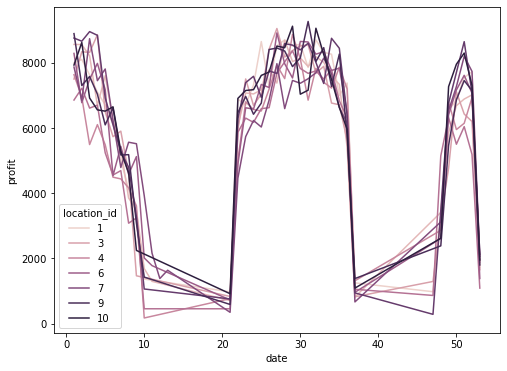

In [4]:
# rental Profit Variation
# We have cyclic pattern - Large profits during winter with snow tubing and during summer with river tubing
# This result indicates we should include the time dependence into account for modelling the profit for each location
df = df_profit
plt.figure(figsize=(8,6))
sns.lineplot(data=df.groupby([df['date'].dt.weekofyear, df['location_id']]).agg({'profit':'sum'}), x='date', y='profit', hue='location_id')

In [317]:
df_profit_norm_monthly

,location_id,profit,temperature,pressure,humidity,cloudy,precipitation,day_of_year,population,elevation,season
0,1,0.558449,0.080927,0.500632,0.035088,0.447368,0.245614,0.001122,0.013915,0.592476,w
1,2,0.578728,0.083050,0.496421,0.189495,0.538462,0.316239,0.000741,0.049049,0.275862,w
2,3,0.611029,0.097466,0.372743,0.227675,0.508621,0.336207,0.001141,0.148920,1.000000,w
3,4,0.396753,0.000000,0.464255,0.147493,0.504425,0.238938,0.000159,0.003802,0.545455,w
4,5,0.400674,0.027736,0.493030,0.054131,0.429825,0.201754,0.001804,0.000000,0.626959,w
...,...,...,...,...,...,...,...,...,...,...,...
95,6,0.829249,0.121555,0.438576,0.210892,0.616279,0.569767,0.998922,0.178568,0.780564,w
96,7,0.950388,0.155942,0.512035,0.309264,0.689655,0.563218,0.998710,0.001730,0.000000,w
97,8,1.000000,0.201744,0.392855,0.249820,0.626506,0.554217,0.996630,0.095720,0.664577,w
98,9,0.856604,0.157657,0.478483,0.231990,0.595238,0.523810,1.000000,0.002314,0.514107,w


Text(0.5, 1.08, 'Monthly distribution')

<Figure size 576x432 with 0 Axes>

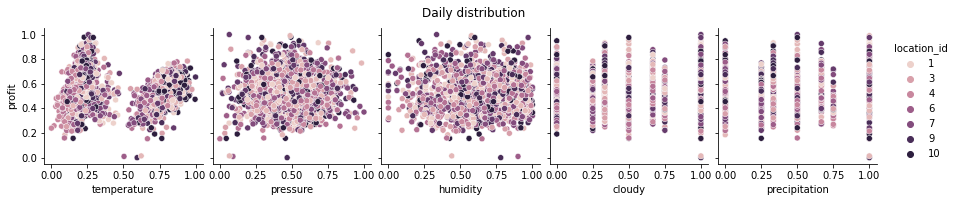

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

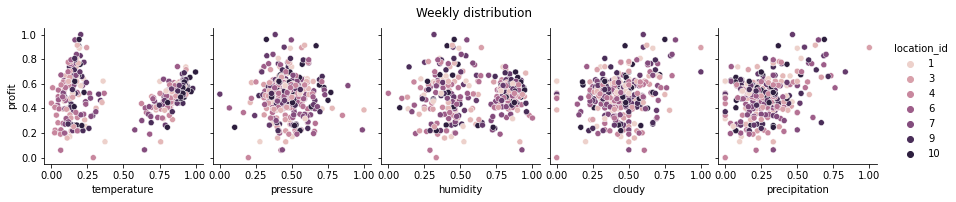

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

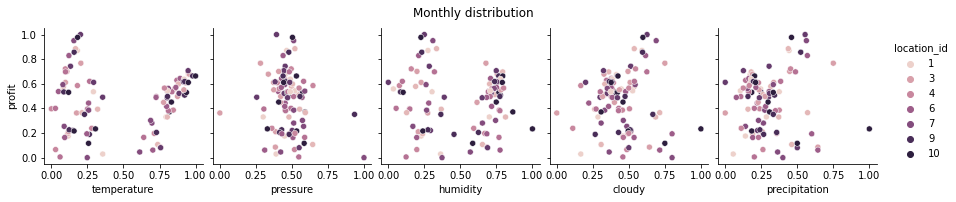

In [5]:
# Here I plotted the distributions of profit as a function of temperature for three different time windows
# Dt = {daily, weekly, monthly}
# Visually, the weekly time frame seems to capture the correlation with less noise
df = df_profit
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df_profit_norm_daily, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation'], y_vars='profit', hue='location_id')
s.fig.suptitle('Daily distribution', y=1.08)

plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df_profit_norm_weekly, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation'], y_vars='profit', hue='location_id')
s.fig.suptitle('Weekly distribution', y=1.08)

plt.figure(figsize=(8,6))
plt.figure(figsize=(8,6))
s = sns.pairplot(data=df_profit_norm_monthly, x_vars=['temperature','pressure', 'humidity', 'cloudy', 'precipitation'], y_vars='profit', hue='location_id')
s.fig.suptitle('Monthly distribution', y=1.08)

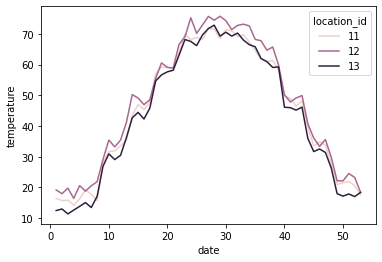

In [157]:
df = df_weather[df_weather['location_id'].isin([11,12,13])]
sns.lineplot(data=df.groupby([df['date'].dt.weekofyear, df['location_id']]).agg({'temperature':'mean'}), x='date', y='temperature', hue='location_id')
#sns.lineplot(data=df.groupby([df['date'].dt.month, df['location_id']]).agg({'temperature':'mean'}), x='date', y='temperature', hue='location_id', linestyle='--')

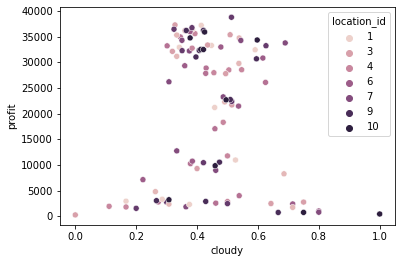

In [88]:
df = df_profit#[df_profit['location_id'].isin([1,2])]
sns.scatterplot(data=df.groupby([df['date'].dt.month, df['location_id']]).agg({'profit':'sum', 'cloudy':'mean'}), x='cloudy', y='profit', hue='location_id')

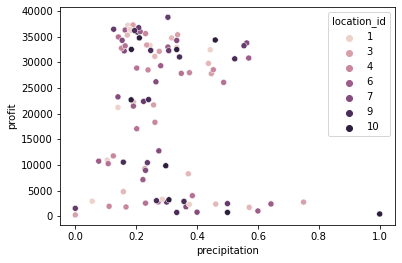

In [6]:
df = df_profit
sns.scatterplot(data=df.groupby([df['date'].dt.month, df['location_id']]).agg({'profit':'sum', 'precipitation':'mean'}), x='precipitation', y='profit', hue='location_id')

In [142]:
df_profit['date'].dt.year

0       2019
1       2019
2       2019
3       2019
4       2019
        ... 
7636    2022
7637    2022
7639    2022
7640    2022
7641    2022
Name: date, Length: 7252, dtype: int64

In [136]:
df_profit.groupby([df_profit['date'].dt.month,df_profit['location_id']]).agg({'profit':'count'})

profit
date location_id        
1    1               114
     2               117
     3               116
     4               113
     5               114
...                  ...
12   6                86
     7                87
     8                83
     9                84
     10               87

[100 rows x 1 columns]

In [154]:
df_profit[(df_profit['date'].dt.month == 3) & (df_profit['location_id'] == 1)]

,location_id,date,profit,temperature,pressure,humidity,cloudy,precipitation,season,day_of_year,population,elevation
58,1,2019-03-01,161.43,24.44,1016.995305,0.00,0.0,0.0,w,60.0,18428,375
252,1,2020-03-01,195.88,33.08,1008.298122,0.75,0.0,0.0,s,61.0,18428,375
253,1,2020-03-02,112.15,36.32,990.457746,0.52,0.0,0.0,s,62.0,18428,375
254,1,2020-03-03,95.45,36.14,963.251174,0.41,0.0,0.0,s,63.0,18428,375
255,1,2020-03-04,118.07,35.60,1021.009390,0.08,0.0,0.0,s,64.0,18428,375
256,1,2020-03-05,87.87,26.42,1028.814554,1.00,1.0,1.0,w,65.0,18428,375
257,1,2020-03-06,190.26,28.76,1018.110329,0.90,1.0,0.0,w,66.0,18428,375
653,1,2022-03-01,182.18,33.98,971.725352,0.64,0.0,0.0,s,60.0,18428,375
654,1,2022-03-02,146.06,28.76,992.464789,0.90,0.0,0.0,w,61.0,18428,375
655,1,2022-03-03,142.68,24.26,1018.556338,0.07,0.0,0.0,w,62.0,18428,375


In [180]:
df_profit_norm_daily

profit  temperature  pressure  humidity  cloudy  \
date location_id                                                      
2    1            0.625411     0.145228  0.560000  0.520000    0.00   
     2            0.682216     0.138485  0.367059  0.435000    0.50   
     3            0.645865     0.209025  0.405294  0.500000    0.25   
     4            0.646499     0.089212  0.331176  0.585000    0.50   
     5            0.680786     0.170816  0.443922  0.426667    0.00   
...                    ...          ...       ...       ...     ...   
366  6            0.450920     0.180498  0.795294  0.360000    1.00   
     7            0.667753     0.248963  0.336471  0.650000    0.00   
     8            0.645695     0.278008  0.898824  0.000000    1.00   
     9            0.627431     0.207469  0.861176  0.860000    1.00   
     10           0.438672     0.124481  0.680000  0.730000    1.00   

                  precipitation  day_of_year  population  elevation season  
date location_id                                                            
2    1                     0.00          0.0    0.013915   0.592476      w  
     2                     0.25          0.0    0.049049   0.275862      w  
     3                     0.25          0.0    0.148920   1.000000      w  
     4                     0.50          0.0    0.003802   0.545455      w  
     5                     0.00          0.0    0.000000   0.626959      w  
...                         ...          ...         ...        ...    ...  
366  6                     1.00          1.0    0.178568   0.780564      w  
     7                     0.00          1.0    0.001730   0.000000      w  
     8                     0.00          1.0    0.095720   0.664577      w  
     9                     0.00          1.0    0.002314   0.514107      w  
     10                    0.00          1.0    1.000000   0.250784      w  

[2152 rows x 10 columns]

Text(0.5, 1.0, 'Profit correlation - Weekly window')

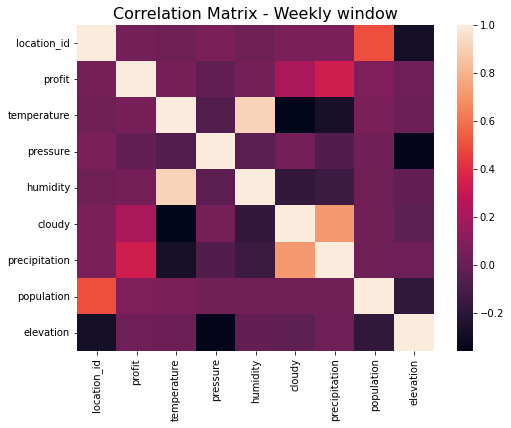

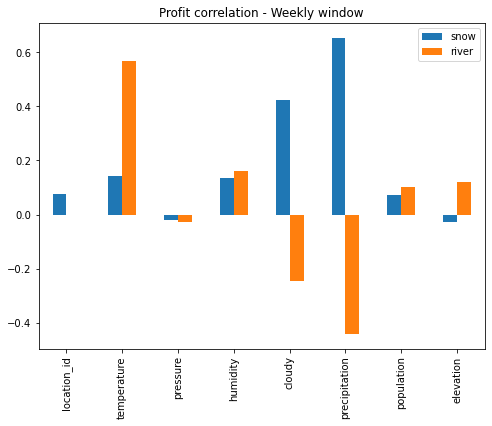

In [7]:
# Correlation Matrix for normalized Dt=daily profit dataframe
fig = plt.figure(figsize=(8, 6))
h = sns.heatmap(df_profit_norm_weekly.corr())
#plt.xticks(range(df_profit_norm.select_dtypes(['number']).shape[1]), df_profit_norm.select_dtypes(['number']).columns, fontsize=14, rotation=45)
#plt.yticks(range(df_profit_norm.select_dtypes(['number']).shape[1]), df_profit_norm.select_dtypes(['number']).columns, fontsize=14)
#cb = plt.colorbar()
#cb.ax.tick_params(labelsize=14)
h.set_title('Correlation Matrix - Weekly window', fontsize=16)

# Profit correlation to the other variables
df_cor = pd.DataFrame()
for rent in ['snow', 'river']:
    df_cor[rent] = df_profit_norm_weekly[df_profit_norm_weekly['rent']==rent].corr()['profit'].drop('profit')
df_cor.plot.bar(figsize=(8, 6))
#df_nor[df_nor['rent']=='river'].corr()['profit'].drop('profit').plot.bar()
plt.title('Profit correlation - Weekly window')

In [230]:
# PCA - Principal Component Analysis
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(df_nor)

TypeError: invalid type promotion

In [277]:
df

,location_id,date,profit,temperature,pressure,humidity,cloudy,precipitation,season,day_of_year,population,elevation
0,1,2019-01-02,0.726686,0.207469,0.835294,0.44,0.0,0.0,w,0.000000,0.013915,0.592476
1,1,2019-01-03,0.706403,0.211618,0.640000,0.58,0.0,0.0,w,0.002747,0.013915,0.592476
2,1,2019-01-04,0.509132,0.120332,0.771765,0.00,1.0,0.0,w,0.005495,0.013915,0.592476
3,1,2019-01-05,0.705075,0.244813,0.854118,0.87,1.0,0.0,w,0.008242,0.013915,0.592476
4,1,2019-01-06,0.699622,0.211618,0.275294,0.80,0.0,0.0,w,0.010989,0.013915,0.592476
...,...,...,...,...,...,...,...,...,...,...,...,...
7636,10,2022-09-06,0.748427,0.721992,0.487059,0.60,0.0,0.0,s,0.678571,1.000000,0.250784
7637,10,2022-09-07,0.728548,0.765560,0.964706,0.93,0.0,0.0,s,0.681319,1.000000,0.250784
7639,10,2022-09-09,0.284696,0.678423,0.157647,0.97,1.0,1.0,s,0.686813,1.000000,0.250784
7640,10,2022-09-10,0.645767,0.724066,0.181176,0.83,0.0,0.0,s,0.689560,1.000000,0.250784


Model river 0.5239659910596858
Model snow 0.23329796710451323


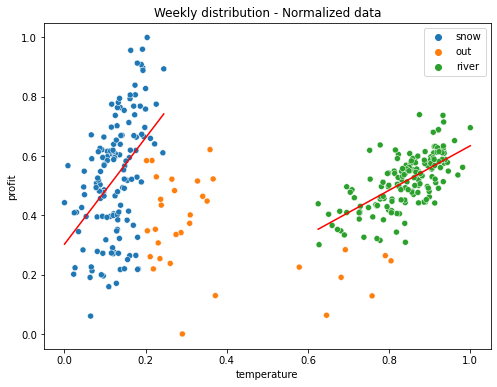

In [19]:
# Linear Regression Model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Remove outliners
df = df_profit_norm_weekly.copy()
df['rent'] = df[['rent', 'profit', 'temperature']].apply(lambda x: 'out' if (x['profit'] < 0.6) & (x['temperature'] > 0.2) & (x['rent'] == 'snow') else x['rent'], axis=1)
df['rent'] = df[['rent', 'profit', 'temperature']].apply(lambda x: 'out' if ((x['profit'] < 0.3) or (x['temperature'] < 0.6)) & (x['rent'] == 'river') else x['rent'], axis=1)

# Plot dataframe distribution
plt.figure(figsize=(8,6))
s = sns.scatterplot(data=df, x='temperature', y='profit', hue='rent')
s.set_title('Weekly distribution - Normalized data')

# Train-Test data
# Season dependent model
# River tubing and Snow tubing
model = []
for rent in ['river', 'snow']:
    #x = df.loc[df['rent']==rent,['temperature', 'pressure', 'humidity', 'cloudy', 'precipitation', 'population', 'elevation']].to_numpy()
    x = df.loc[df['rent']==rent,['temperature']].to_numpy()
    y = df.loc[df['rent']==rent,'profit'].to_numpy()
    y = y.reshape(-1, 1)

    # Linear model training
    xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

    # Model Fit + Prediction
    model.append(LinearRegression())
    model[-1].fit(xtrain, ytrain)
    #model[-1].fit(x, y)
    ypred = (model[-1].predict(xtest))
    print('Model',rent,model[-1].score(xtest,ytest))

    # Plotting linear regression
    line_x = np.linspace(x[:,0].min(), x[:,0].max(), 2)
    line_y = model[-1].intercept_[0] + model[-1].coef_[0][0]*line_x
    sns.lineplot(x=line_x, y=line_y, linestyle='-', color='red')
#plt.text(line_x[-1]*1.1, line_y[-1]*1.1, f"R^2 = {rent}", horizontalalignment='left', size='medium', color='black')
#s.legend(labels=['Summer', 'Winter'])

In [16]:
model[0].score(xtest,ytest)

-4.051313434446004

In [275]:
line_x, line_y

(array([0., 0.]), array([0.2965599, 0.2965599]))

In [272]:
model[-1].coef_

array([[0.39559239]])

In [24]:
model.score(xtest, ytest)

0.05988562351836113

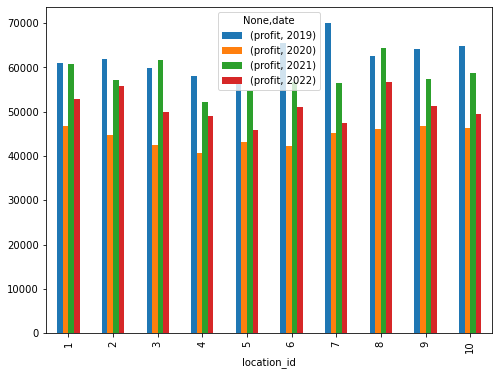

In [131]:
# Profit of each location for each year
df_yea = df_transaction.groupby([df_transaction['location_id'],df_transaction['date'].dt.year])[['profit']].agg('sum')
df_yea.unstack('date').plot.bar(figsize=(8,6))

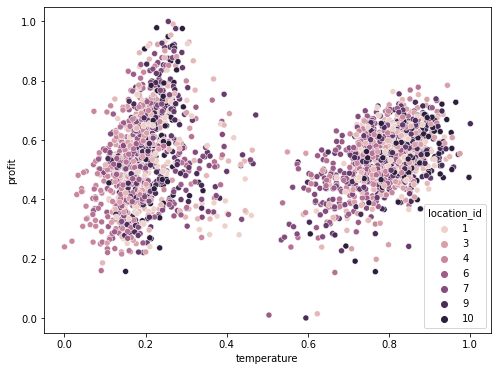

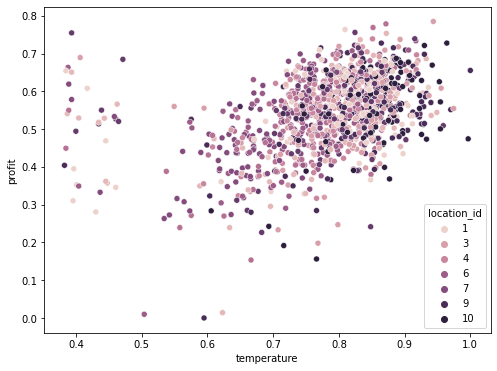

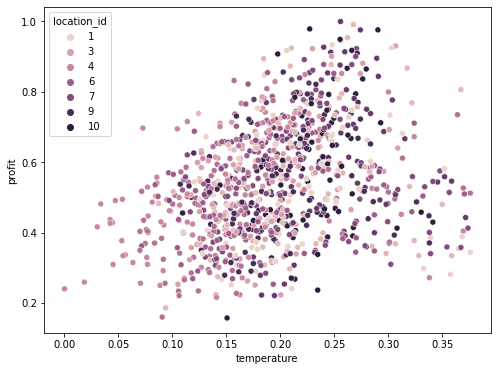

In [287]:
# Total profit for each day for all locations
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_profit_norm_daily, x='temperature', y='profit', hue='location_id')

plt.figure(figsize=(8,6))
sns.scatterplot(data=df_profit_norm_daily[df_profit_norm_daily['rent']=='river'], x='temperature', y='profit', hue='location_id')
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_profit_norm_daily[df_profit_norm_daily['rent']=='snow'], x='temperature', y='profit', hue='location_id')

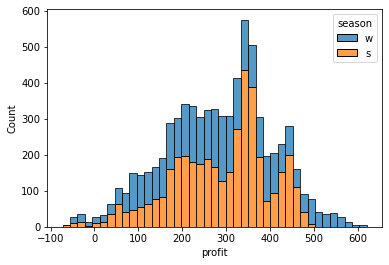

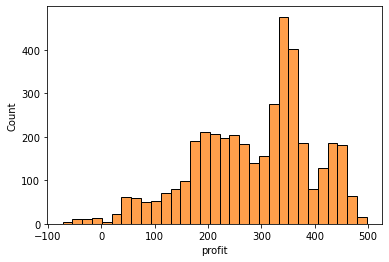

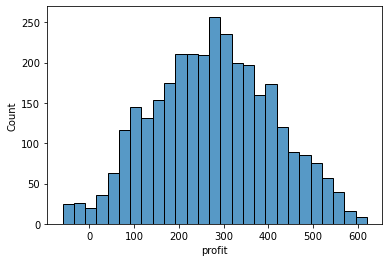

In [35]:
# Total profit for each day for all locations
sns.histplot(data=df_profit, x='profit', hue='rent', multiple='stack')

plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='river'], x='profit', color='C1')
plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='snow'], x='profit')

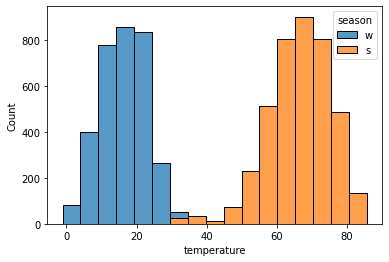

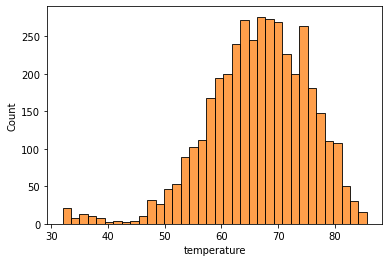

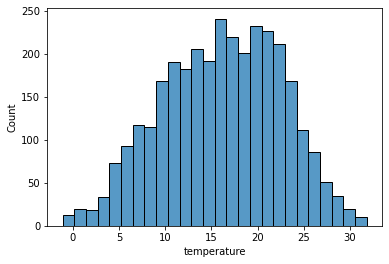

In [34]:
# Total profit for each day for all locations
sns.histplot(data=df_profit, x='temperature', hue='rent', multiple='stack')

plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='river'], x='temperature', color='C1')
plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='snow'], x='temperature')

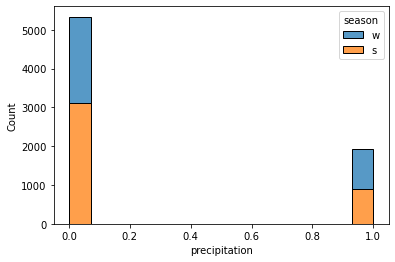

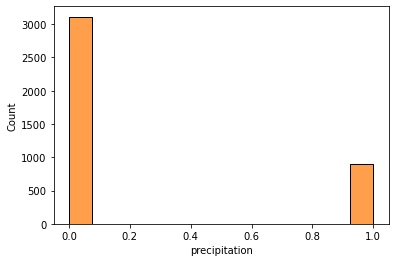

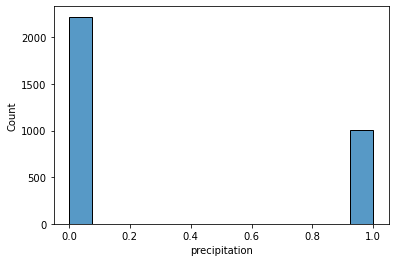

In [36]:
# Total profit for each day for all locations
sns.histplot(data=df_profit, x='precipitation', hue='rent', multiple='stack')

plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='river'], x='precipitation', color='C1')
plt.figure()
sns.histplot(data=df_profit[df_profit['rent']=='snow'], x='precipitation')

In [290]:
df_profit_norm_daily

profit  temperature  pressure  humidity  cloudy  \
date location_id                                                      
2    1            0.672462     0.131094  0.555283  0.520000    0.00   
     2            0.738479     0.124052  0.353808  0.435000    0.50   
     3            0.696233     0.197725  0.393735  0.500000    0.25   
     4            0.696970     0.072589  0.316339  0.585000    0.50   
     5            0.736817     0.157819  0.434070  0.426667    0.00   
...                    ...          ...       ...       ...     ...   
366  6            0.469674     0.167931  0.800983  0.360000    1.00   
     7            0.721671     0.239437  0.321867  0.650000    0.00   
     8            0.696036     0.269772  0.909091  0.000000    1.00   
     9            0.674809     0.196100  0.869779  0.860000    1.00   
     10           0.455439     0.109426  0.680590  0.730000    1.00   

                  precipitation  day_of_year  population  elevation season  
date location_id                                                            
2    1                     0.00          0.0    0.013915   0.592476      w  
     2                     0.25          0.0    0.049049   0.275862      w  
     3                     0.25          0.0    0.148920   1.000000      w  
     4                     0.50          0.0    0.003802   0.545455      w  
     5                     0.00          0.0    0.000000   0.626959      w  
...                         ...          ...         ...        ...    ...  
366  6                     1.00          1.0    0.178568   0.780564      w  
     7                     0.00          1.0    0.001730   0.000000      w  
     8                     0.00          1.0    0.095720   0.664577      w  
     9                     0.00          1.0    0.002314   0.514107      w  
     10                    0.00          1.0    1.000000   0.250784      w  

[2152 rows x 10 columns]

In [288]:
# Total profit for each day for all locations
col = df_profit_norm_daily['location_id'].map({i:f'C{i}' for i in range(11)})
df_profit_norm_daily.plot.scatter(x='pressure', y='profit', c=col, figsize=(8,6))

col_s = df_profit_norm_daily[df_profit_norm_daily['rent']=='river']['location_id'].map({i:f'C{i}' for i in range(11)})
col_w = df_profit_norm_daily[df_profit_norm_daily['rent']=='snow']['location_id'].map({i:f'C{i}' for i in range(11)})
df_profit_norm_daily[df_profit_norm_daily['rent']=='river'].plot.scatter(x='pressure', y='profit', c=col_s, figsize=(8,6), title='summer')
df_profit_norm_daily[df_profit_norm_daily['rent']=='snow'].plot.scatter(x='pressure', y='profit', c=col_w, figsize=(8,6), title='winter')

KeyError: 'location_id'

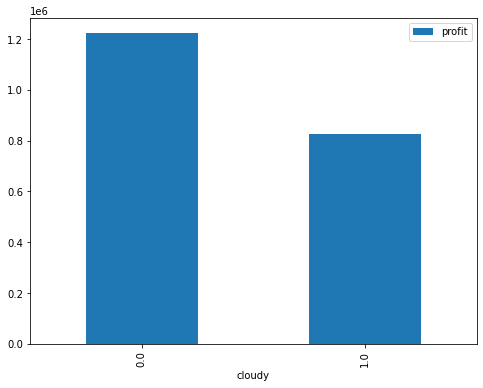

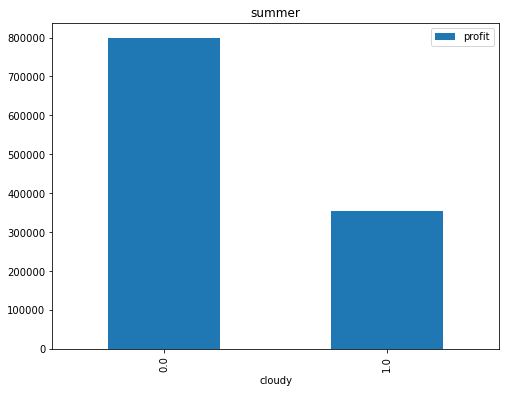

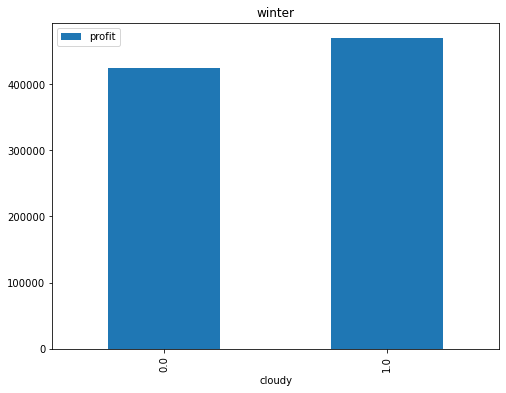

In [46]:
# Total profit for each day for all locations
col = df_profit['location_id'].map({i:f'C{i}' for i in range(11)})
df_profit.groupby('cloudy').agg({'profit':'sum'}).plot.bar(figsize=(8,6))

col_s = df_profit[df_profit['rent']=='river']['location_id'].map({i:f'C{i}' for i in range(11)})
col_w = df_profit[df_profit['rent']=='snow']['location_id'].map({i:f'C{i}' for i in range(11)})
df_profit[df_profit['rent']=='river'].groupby('cloudy').agg({'profit':'sum'}).plot.bar(figsize=(8,6), title='summer')
df_profit[df_profit['rent']=='snow'].groupby('cloudy').agg({'profit':'sum'}).plot.bar(figsize=(8,6), title='winter')

In [65]:
df_profit.describe()

,location_id,profit,temperature,pressure,humidity,cloudy,precipitation,population,elevation
count,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000,7252.000000
mean,5.493657,282.255153,43.993356,1001.474523,0.691995,0.438776,0.264341,73363.085080,352.880033
std,2.863817,120.936549,26.236902,25.112211,0.305839,0.496272,0.441012,118531.950909,87.194837
min,1.000000,-72.750000,-1.120000,955.000000,0.000000,0.000000,0.000000,12686.000000,186.000000
25%,3.000000,198.190000,17.420000,979.920775,0.550000,0.000000,0.000000,13641.000000,274.000000
50%,6.000000,292.905000,55.220000,1001.384977,0.800000,0.000000,0.000000,18428.000000,375.000000
75%,8.000000,362.292500,68.000000,1023.016432,0.930000,1.000000,1.000000,74138.000000,398.000000
max,10.000000,620.410000,85.640000,1049.776995,1.000000,1.000000,1.000000,425336.000000,505.000000
